# 💊 Drug Detection

## Preprocessing

* Dropping duplicates (Also performed during Final Dataset creation)
* Dropping missing or infinite values (Also performed during Final Dataset creation)
* Split the Data into Train(80%) and Test set(20%)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("Dataset/final/dataset.csv")

# Drop duplicates (SMILES-based)
df.drop_duplicates(subset=["smiles"], keep="first", inplace=True)

# Drop full duplicate rows if any
df.drop_duplicates(inplace=True)

# Drop rows with NaN or ±inf in any column
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Split features and target
x = df.drop(columns=["smiles", "Is Drug"])
y = df["Is Drug"]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (9442, 2221)
x_test shape: (2361, 2221)
y_train shape: (9442,)
y_test shape: (2361,)


### Visualize distributions (boxplot + histogram) of physicochemical features

  The distributions are heavily right skewed(_except for clogP and Ring Count_) and has many outliers.

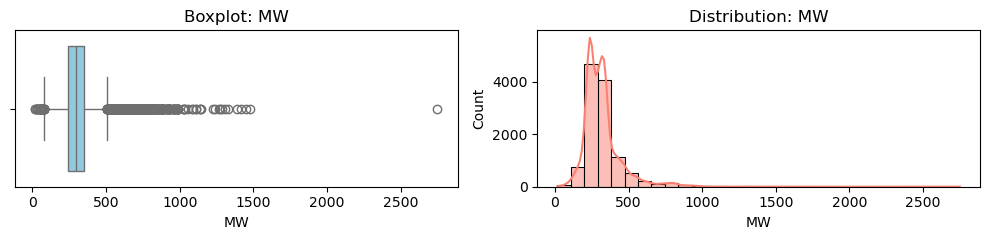

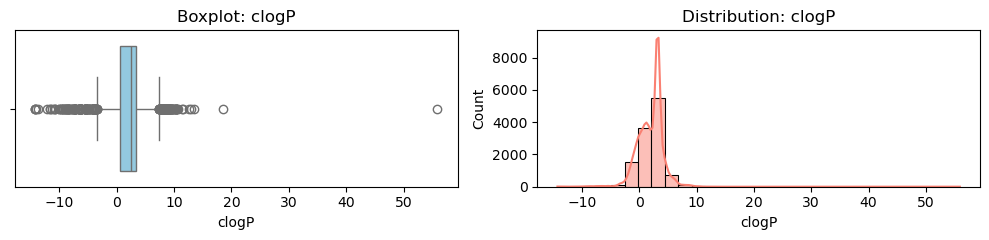

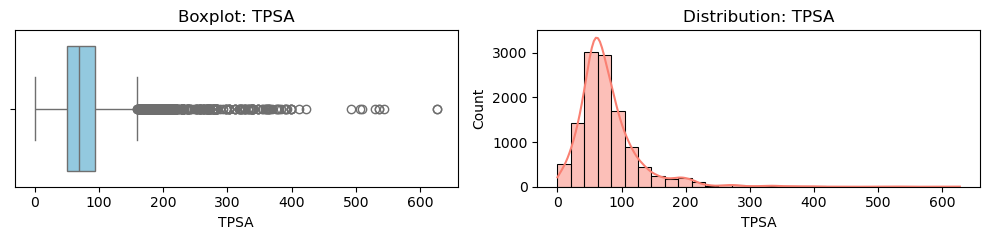

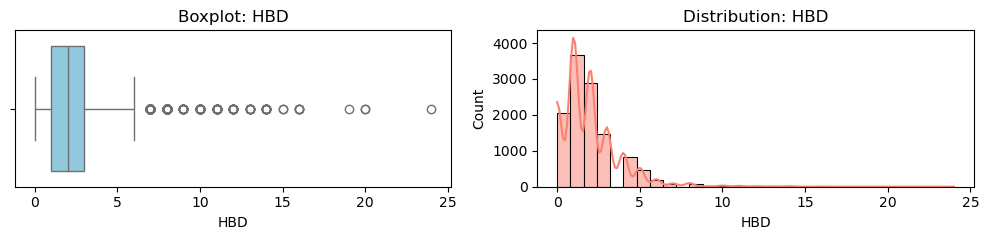

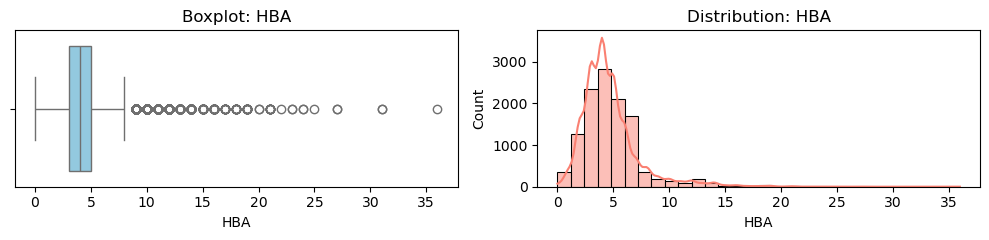

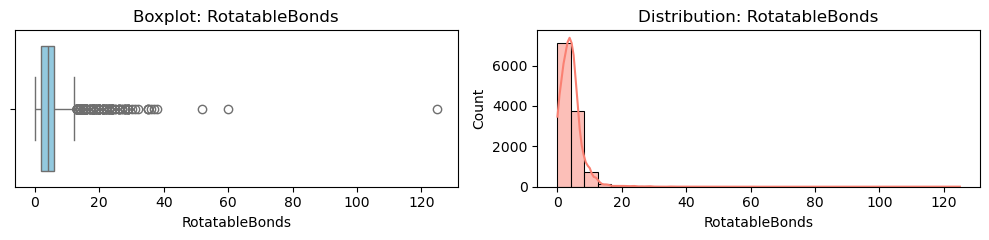

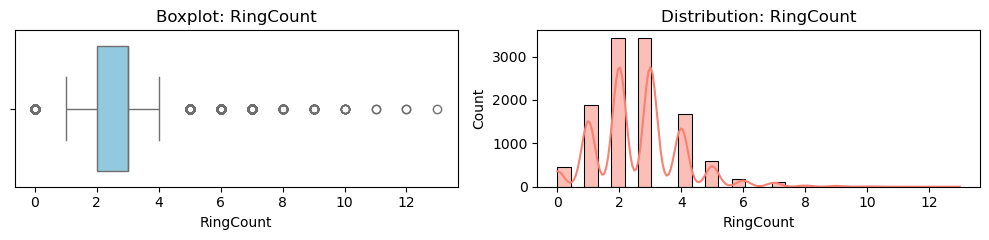

In [17]:
physicochemical_features = [
    "MW","clogP","TPSA","HBD","HBA","RotatableBonds","RingCount"
]

for feature in physicochemical_features:

    fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))

    # Boxplot
    sns.boxplot(x=x[feature], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Boxplot: {feature}')

    # Histogram + KDE
    sns.histplot(x[feature], kde=True, bins=30, ax=axes[1], color='salmon')
    axes[1].set_title(f'Distribution: {feature}')

    plt.tight_layout()
    plt.show()

### Scaling

* Applies np.log1p() to skewed descriptors

* Leaves clogP and RingCount untouched since they are not heavily skewed

* Uses RobustScaler on all 7 descriptors

* Leaves ECFP4 and MACCS untouched since they are binary (0/1) values

* Outputs x_train_scaled, x_test_scaled

In [18]:
from sklearn.preprocessing import RobustScaler

log_transform_features = ["MW", "TPSA", "HBD", "HBA", "RotatableBonds"]  # Exclude clogP and RingCount

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[log_transform_features] = x_train_scaled[log_transform_features].apply(np.log1p)
x_test_scaled[log_transform_features] = x_test_scaled[log_transform_features].apply(np.log1p)

# === 7. Apply RobustScaler ONLY on the 7 descriptors ===
scaler = RobustScaler()
x_train_scaled[physicochemical_features] = scaler.fit_transform(x_train_scaled[physicochemical_features])
x_test_scaled[physicochemical_features] = scaler.transform(x_test_scaled[physicochemical_features])

# === 8. Final output ===
# x_train_log and x_test_log contain full scaled feature sets: descriptors + untouched fingerprints
print("✅ Preprocessing complete.")
print("x_train shape:", x_train_scaled.shape)
print("x_test shape:", x_test_scaled.shape)

✅ Preprocessing complete.
x_train shape: (9442, 2221)
x_test shape: (2361, 2221)


### Dimensionality Reduction

Reducing ECFP4 + MACCS dimensions and combining them with the already-scaled descriptors:

In [19]:
from sklearn.feature_selection import VarianceThreshold

# === 1. Identify fingerprint columns
descriptor_cols = ["MW", "clogP", "TPSA", "HBD", "HBA", "RotatableBonds", "RingCount"]
fingerprint_cols = [col for col in x_train.columns if col not in descriptor_cols]

# === 2. Apply VarianceThreshold on fingerprint columns
vt = VarianceThreshold(threshold=0.01)
x_train_fp_reduced = vt.fit_transform(x_train_scaled[fingerprint_cols])
x_test_fp_reduced = vt.transform(x_test_scaled[fingerprint_cols])

# === 3. Combine reduced fingerprints with scaled descriptors
x_train_final = np.concatenate([x_train_scaled[descriptor_cols].values, x_train_fp_reduced], axis=1)
x_test_final = np.concatenate([x_test_scaled[descriptor_cols].values, x_test_fp_reduced], axis=1)

print("✅ Fingerprint reduction complete.")
print(f"Original fingerprint count: {len(fingerprint_cols)}")
print(f"Reduced fingerprint count: {x_train_fp_reduced.shape[1]}")
print(f"Final feature shape: {x_train_final.shape}")


✅ Fingerprint reduction complete.
Original fingerprint count: 2214
Reduced fingerprint count: 1038
Final feature shape: (9442, 1045)


### Feature Selection with SelectKBest(f_classif)

* This selects the 300 best features based on their statistical relationship to the target.

* It works well for high-dimensional datasets like these, especially with many sparse/binary features.

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

# === Select top 300 most informative features (based on ANOVA F-test) ===
selector = SelectKBest(score_func=f_classif, k=300)
x_train_selected = selector.fit_transform(x_train_final, y_train)
x_test_selected = selector.transform(x_test_final)

print("✅ Feature selection complete.")
print("Original feature count:", x_train_final.shape[1])
print("Selected feature count:", x_train_selected.shape[1])


✅ Feature selection complete.
Original feature count: 1045
Selected feature count: 300


### 🔁 Cross-Validation (Train Set Only)

We perform 5-fold cross-validation using only the training data to estimate the model's generalization performance without data leakage. ROC-AUC is used as the scoring metric.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Reinitialize model
model_cv = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000)

# Perform 5-fold CV on training set only
cv_scores = cross_val_score(model_cv, x_train_selected, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation ROC-AUC scores (train set only):", cv_scores)
print(f"Mean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation ROC-AUC scores (train set only): [0.96185544 0.95822908 0.96217861 0.96492903 0.94987073]
Mean AUC: 0.9594 ± 0.0052


### 🧪 Final Model Training and Evaluation on Held-out Test Set

After performing cross-validation and selecting the best model configuration, we now train the model on the entire training set and evaluate its performance on the held-out test set.

This provides an unbiased estimate of the model’s real-world predictive ability.

Metrics evaluated:
- ROC-AUC Score
- ROC Curve visualization
- Precision, Recall, F1-score (via classification report)
- Confusion Matrix (in earlier cell)


Test ROC-AUC Score: 0.9672


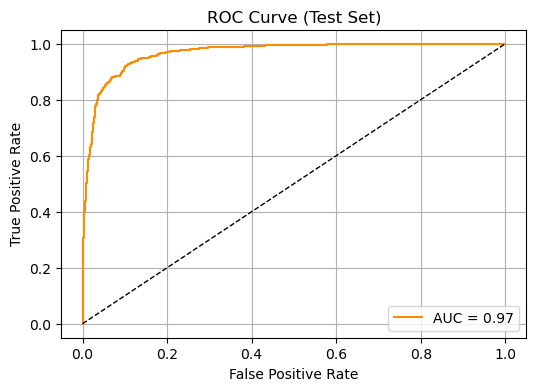


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1181
           1       0.90      0.92      0.91      1180

    accuracy                           0.91      2361
   macro avg       0.91      0.91      0.91      2361
weighted avg       0.91      0.91      0.91      2361



In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Fit the model on full training set
final_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000)
final_model.fit(x_train_selected, y_train)

# Predict probabilities on test set
y_proba = final_model.predict_proba(x_test_selected)[:, 1]

# ROC-AUC Score
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC Score: {test_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
y_pred = final_model.predict(x_test_selected)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### 📊 Confusion Matrix

The confusion matrix shows the number of correct and incorrect predictions made by the classifier. This helps visualize how well the model distinguishes between drug and non-drug molecules.

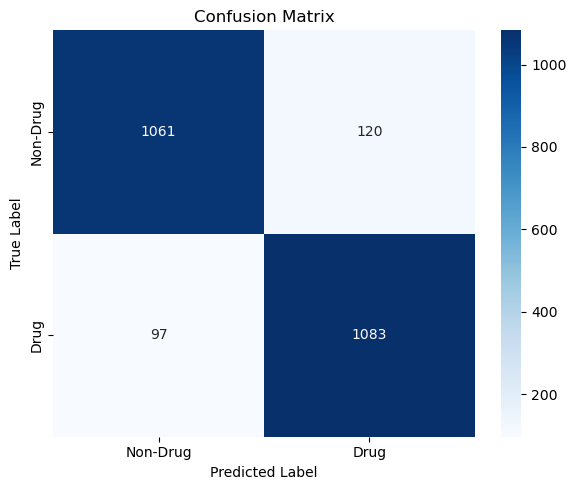

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict test labels
y_pred = final_model.predict(x_test_selected)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Drug", "Drug"], yticklabels=["Non-Drug", "Drug"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### 🔍 Feature Importance – Top Contributing Features

Below are the top 15 features (fingerprints or descriptors) that most influence the logistic regression model. Positive coefficients push predictions toward "Drug", while negative values push toward "Non-Drug".


        Feature  Coefficient
228    MACCS_56    -2.545033
224    MACCS_49     1.966095
198  ECFP4_1963    -1.719001
169  ECFP4_1691    -1.585026
106  ECFP4_1061    -1.496964
166  ECFP4_1627    -1.490943
295   MACCS_160    -1.441246
116  ECFP4_1167     1.383536
213    MACCS_22    -1.378188
30    ECFP4_291    -1.335709
215    MACCS_29     1.329152
39    ECFP4_381     1.320670
73    ECFP4_713     1.292500
69    ECFP4_691     1.269025
6       ECFP4_4     1.228640


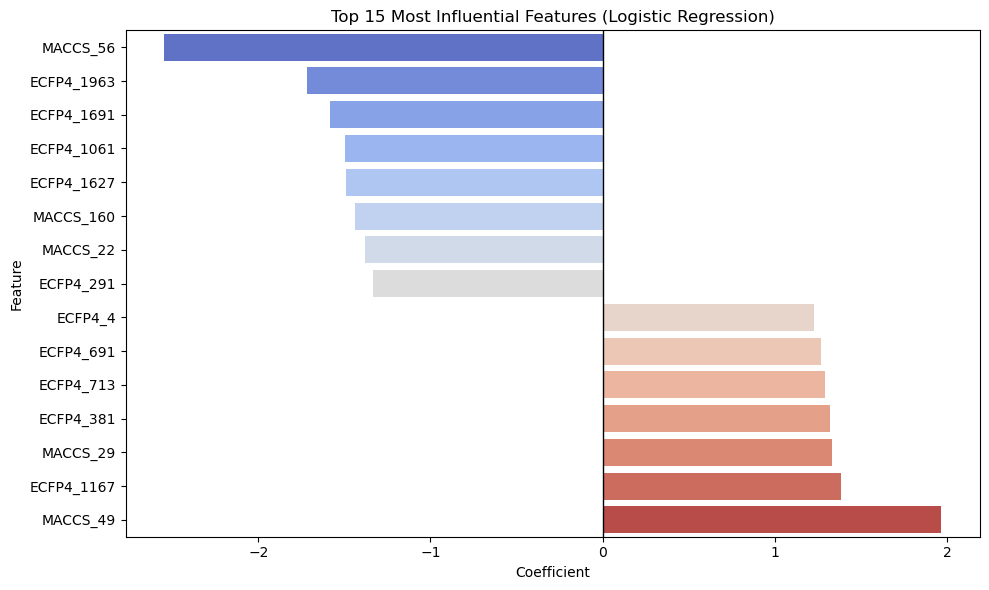

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get final list of selected features (after SelectKBest)
selected_feature_indices = selector.get_support(indices=True)

# Build combined feature name list: descriptors + reduced fingerprints
descriptor_names = x_train_scaled[descriptor_cols].columns.tolist()
fingerprint_names = vt.get_feature_names_out(input_features=fingerprint_cols).tolist()

# Combine names (same order as in x_train_final before SelectKBest)
combined_feature_names = descriptor_names + fingerprint_names

# Now get only those that survived SelectKBest
selected_feature_names = [combined_feature_names[i] for i in selected_feature_indices]

# Map to model coefficients
coefficients = final_model.coef_[0]
feature_contributions = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': coefficients,
    'Abs(Coefficient)': np.abs(coefficients)
})

# Sort by absolute contribution
top_features = feature_contributions.sort_values(by='Abs(Coefficient)', ascending=False).head(15)
print(top_features[['Feature', 'Coefficient']])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features.sort_values("Coefficient"),
    y="Feature",
    x="Coefficient",
    hue="Feature",
    dodge=False,
    palette="coolwarm",
    legend=False
)
plt.axvline(0, color='black', linewidth=1)
plt.title("Top 15 Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



### 💾 Exporting the Final Model

To preserve the trained model for later use, we save it using `joblib`. This allows us to reload and use the model without needing to retrain from scratch.


In [25]:
import joblib

# Save the final trained model
joblib.dump(final_model, "Model/final_logistic_regression_model.pkl")

print("✅ Model saved to 'Model/final_logistic_regression_model.pkl'")


✅ Model saved to 'Model/final_logistic_regression_model.pkl'
